In [99]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from matplotlib import pyplot as plt
from keras.utils import plot_model
import graphviz
import pydot
import keras
import numpy as np
import os
import random
import tensorflow as tf
from IPython.display import clear_output
import argparse
from keras.callbacks import ModelCheckpoint
from datetime import datetime

In [100]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [101]:
# Get images


Xtrain=[]
Ytrain=[]

for filename in os.listdir('/home/project67/ML_DATA/JPEG96/JPEG96'):
    img = img_to_array(load_img('/home/project67/ML_DATA/JPEG96/JPEG96/'+filename))
    img = img * (1/255)
    img = rgb2lab(img)

    x = img[:,:,0] #L
    y = img[:,:,1:]/128 #ab
    
    x = np.array(x,dtype=float)
    Xtrain.append(x)
    
    y = np.array(y,dtype=float)
    Ytrain.append(y)
    
    

In [103]:
# # COLORING MODEL RECIEVE 96*96*1 AND GENERATE 96*96*2
modelColor = Sequential()
modelColor.add(InputLayer(input_shape=(96, 96,1)))
modelColor.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelColor.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
modelColor.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
modelColor.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
modelColor.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
modelColor.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
modelColor.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
modelColor.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
modelColor.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
modelColor.add(UpSampling2D((2, 2)))
modelColor.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelColor.add(UpSampling2D((2, 2)))
modelColor.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
modelColor.add(UpSampling2D((2, 2)))
modelColor.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

modelColor.compile(optimizer='rmsprop', loss='mse')#mse is (1/n)sigma i in range 1 to n (Yi-Yi')^2
# Generate training data
batch_size = 128
epochs = 64
steps_per_epoch = 4

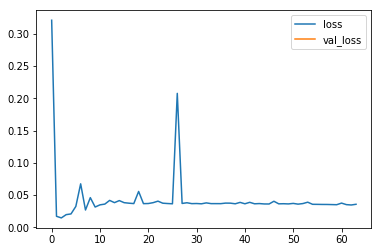

4/4 [==============================] - 2s 381ms/step - loss: 0.0357


In [84]:

# def image_Lab_gen(inputt, outputt, batch_size):
#     xx=np.expand_dims(inputt, axis=3)
#     x_batch = np.zeros((batch_size, 96, 96,1))
#     y_batch = np.zeros((batch_size, 96, 96, 2))
#     while True:
#         for i in range(batch_size):
#             x_batch[i] = xx[i]
#             y_batch[i] = outputt[i]
#             yield (x_batch, y_batch)
        

# # Train model + validation addition
# tensorboard = TensorBoard(log_dir='/home/project67/ML_DATA/JPEG96/log')
# modelColor.fit_generator(image_Lab_gen(Xtrain,Ytrain,batch_size),callbacks=[plot_losses, tensorboard], epochs=epochs, steps_per_epoch=steps_per_epoch)


In [104]:
Xtrain=np.expand_dims(Xtrain, axis=3)




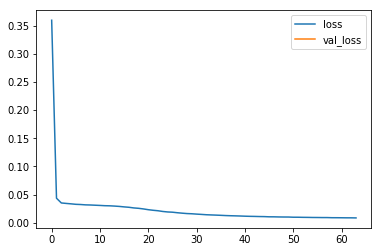

8189/8189 [==============================] - 46s 6ms/step - loss: 0.0087


In [108]:
modelColor.fit(np.array(Xtrain),np.array(Ytrain),batch_size,callbacks=[plot_losses, tensorboard], epochs=epochs)

In [120]:
# Change to '/data/images/Test/' to use all the 500 images
color_me = []
L_images = []
for filename in os.listdir('/home/project67/ML_DATA/JPEG96/Test'):
    img = load_img('/home/project67/ML_DATA/JPEG96/Test/'+filename)
    img = img.resize((96,96))
    img = img_to_array(img)
    img = rgb2lab(img/255)
    

    x = img[:,:,0] #L
    x = np.array(x,dtype=float)
    L_images.append(x)
    color_me.append(x)
    
 

color_me = np.expand_dims(color_me, axis=4) 
print(color_me.shape)

(1, 96, 96, 1)


/home/project67/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [121]:
# Test model
ABoutput = modelColor.predict(color_me)
ABoutput = ABoutput*128

# Output colorizations
for i in range(len(color_me)):
    cur = np.zeros((96, 96, 3))
    cur[:,:,0] =  color_me[i][:,:,0]
    cur[:,:,1:] = ABoutput[i]
    cur = lab2rgb(cur)
    # cur = array_to_img(cur)
    imsave("/home/project67/ML_DATA/JPEG96/TestAnswers/"+str(i)+".png", cur)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
